In [1]:
# imports
import os
import sys
sys.path.append("../../")
import numpy as np
import umap
from functions_EDX import *
from VCA import *
import time
import matplotlib.pyplot as plt
from scipy.optimize import nnls 
from scipy.stats import zscore
from datetime import datetime
import seaborn as sns
from skimage.feature import peak_local_max
from matplotlib import cm
import cv2
from sklearn.preprocessing import MinMaxScaler
import random
import tifffile as tf
from pysptools.material_count.vd import HfcVd
from PIL import Image
import matplotlib as mpl

### MPL settings

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Helvetica'

# this one makes the ticks into text in the exported svgs
plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7

## Convenient things

In [3]:
res_xy = 1024
xray_energies_dir = '../../../secondary_data/xray_energies.npz'
xray_energies = np.load(xray_energies_dir)['xray_energies']

## Choose a tile and load preprocessed data

In [4]:
tile_idx = 0

spectrum_folder = '../../../../primary_data/qdot_mosaic/Spectrum2D/pca10/'
file_names = []
tmp = os.listdir(spectrum_folder)
for filename in tmp:
    if filename.endswith('.npz'):
        file_names.append(filename)

file_names = sorted(file_names)
files = [os.path.join(spectrum_folder,file_name) for file_name in file_names]

spectrum_2D = np.load(files[tile_idx])['spectrum_2D']


npz_folder = '../../../../primary_data/qdot_mosaic/NPZ'
file_names = []
tmp = os.listdir(npz_folder)
for filename in tmp:
    if filename.endswith('.npz'):
        file_names.append(filename)

file_names = sorted(file_names)
files = [os.path.join(npz_folder,file_name) for file_name in file_names]

haadf = rebin_XY(np.load(files[tile_idx])['haadf'],1024)
#haadf = (haadf*255).astype('uint8')

### Estimated number of endmembers

In [ ]:
nEM_est = HfcVd(spectrum_2D)
print(nEM_est)

## Embed with UMAP

### Subsample

In [5]:
nTrain_umap = int(0.01*res_xy**2)
np.random.seed(25); n_sample_train = np.random.choice(spectrum_2D.shape[0], nTrain_umap)
spectrum_2D_zscored = zscore(spectrum_2D)

In [6]:
# Apply UMAP directly
start = datetime.now()
umap1 = umap.UMAP(n_components=3, n_neighbors=3, min_dist=0.0, metric='chebyshev',random_state=100)
embeddings = umap1.fit_transform(spectrum_2D_zscored[n_sample_train,:])

end = datetime.now()
# if 3 dimensions for UMAP, which ones to use (0,1,or 2)
dim_a = 0
dim_b = 1

# scaling
scaler = MinMaxScaler()
embeddings = scaler.fit_transform(embeddings)

etime = end-start
print('Duration for UMAP fitting: {}'.format(end - start))

Duration for UMAP fitting: 0:00:09.002891


## Inspect embedding shape

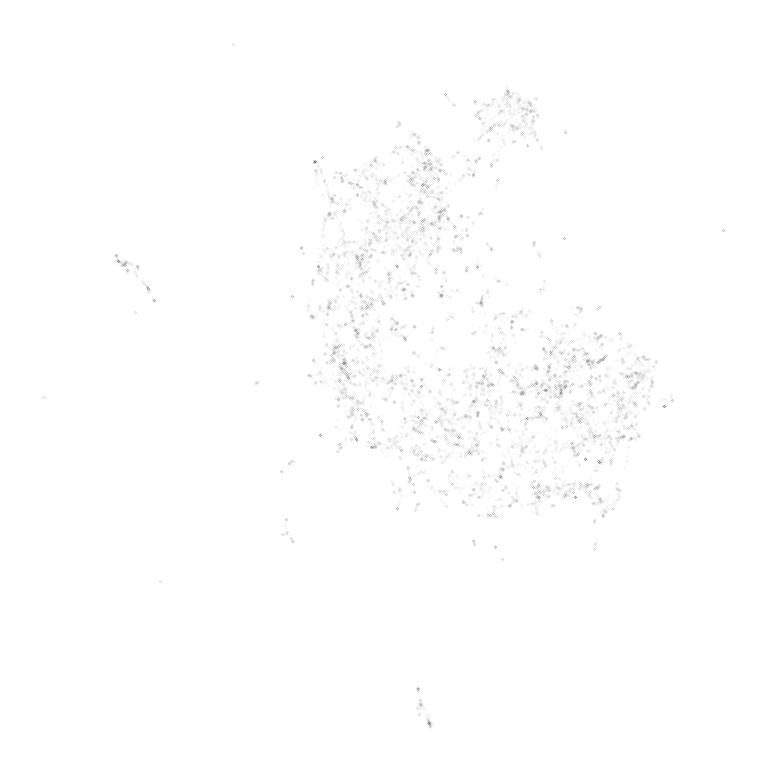

In [7]:
%matplotlib inline 
f, ax = plt.subplots(figsize=(8,8))
sns.despine(left=True, bottom=True, right=True)
ax.set_facecolor((1, 1, 1)) #set gray background if desired
ax.scatter(embeddings[:,dim_a],embeddings[:,dim_b], s=0.001,c='k') 
f.tight_layout() 
plt.axis('off')
plt.show()

## Identify number of endmembers using peak finding

#### Set parameters directly

In [ ]:
#global threshold_rel, min_distance
Grid = 256
threshold_rel = None
min_distance = 15

#find local maxima in 2D histogram
xmin, xmax = np.amin(embeddings[:,dim_a]), np.amax(embeddings[:,dim_a])
ymin, ymax = np.amin(embeddings[:,dim_b]), np.amax(embeddings[:,dim_b])
counts, xedges, yedges = np.histogram2d(embeddings[:,dim_a], embeddings[:,dim_b], bins=Grid)

local_maxi = peak_local_max(counts, threshold_rel = threshold_rel, min_distance = min_distance, exclude_border = False)
local_max_x = []
local_max_y = []

for i in range(0,len(local_maxi)):
    NewValue_X = (((local_maxi[i][0] ) * (xmax - xmin)) / (Grid - 0)) + xmin
    NewValue_Y = (((local_maxi[i][1] - 0) * (ymax - ymin)) / (Grid - 0)) + ymin
    local_max_x.append(NewValue_X)
    local_max_y.append(NewValue_Y)

x = [x for x in zip(local_max_x,local_max_y)]
nEM = len(x)

print(nEM)
    


#### Loop to find parameters based on desired nEM

In [8]:
#global threshold_rel, min_distance
Grid = 256
threshold_rel = None
min_distance = 2     
desired_nEM = 11

nEM = 1000

while abs(desired_nEM-nEM)>=2:

    #find local maxima in 2D histogram
    xmin, xmax = np.amin(embeddings[:,dim_a]), np.amax(embeddings[:,dim_a])
    ymin, ymax = np.amin(embeddings[:,dim_b]), np.amax(embeddings[:,dim_b])
    counts, xedges, yedges = np.histogram2d(embeddings[:,dim_a], embeddings[:,dim_b], bins=Grid)

    local_maxi = peak_local_max(counts, threshold_rel = threshold_rel, min_distance = min_distance, exclude_border = False)
    local_max_x = []
    local_max_y = []

    for i in range(0,len(local_maxi)):
        NewValue_X = (((local_maxi[i][0] ) * (xmax - xmin)) / (Grid - 0)) + xmin
        NewValue_Y = (((local_maxi[i][1] - 0) * (ymax - ymin)) / (Grid - 0)) + ymin
        local_max_x.append(NewValue_X)
        local_max_y.append(NewValue_Y)

    x = [x for x in zip(local_max_x,local_max_y)]
    nEM = len(x)
    print(min_distance,threshold_rel,nEM,end='\r')
    min_distance+=1

    

## Visualize and compute the endmembers

In [9]:
# Plot regions selected from the 2D histogram
min_max = 1*(1/Grid)         #determines bounding box size
points = len(x)
centroid = []                #empty array for selected UMAP centroids
F = []                       #indicies of UMAP points

# colors
cmap = plt.get_cmap('nipy_spectral')
cmap_idx = np.linspace(0, 0.9, nEM)

for i in range(0,points):
    #set bounding square 
    Minx = x[i][0] - min_max
    Maxx = x[i][0] + min_max
    Miny = x[i][1] - min_max
    Maxy = x[i][1] + min_max
    
    #select points
    z3 = [0 if j == 0 else j for j in [j if j <= Maxx else 0 for j in [j if j >= Minx else 0 for j in embeddings[:,dim_a]]]]
    zz3 = [0 if j == 0 else j for j in [j if j <= Maxy else 0 for j in [j if j >= Miny else 0 for j in embeddings[:,dim_b]]]]
    f = [i for i, e in enumerate([x*y for x,y in zip(z3,zz3)]) if e != 0]
    d = embeddings[f]
    F.append(f)
    centroid.append(d)
    


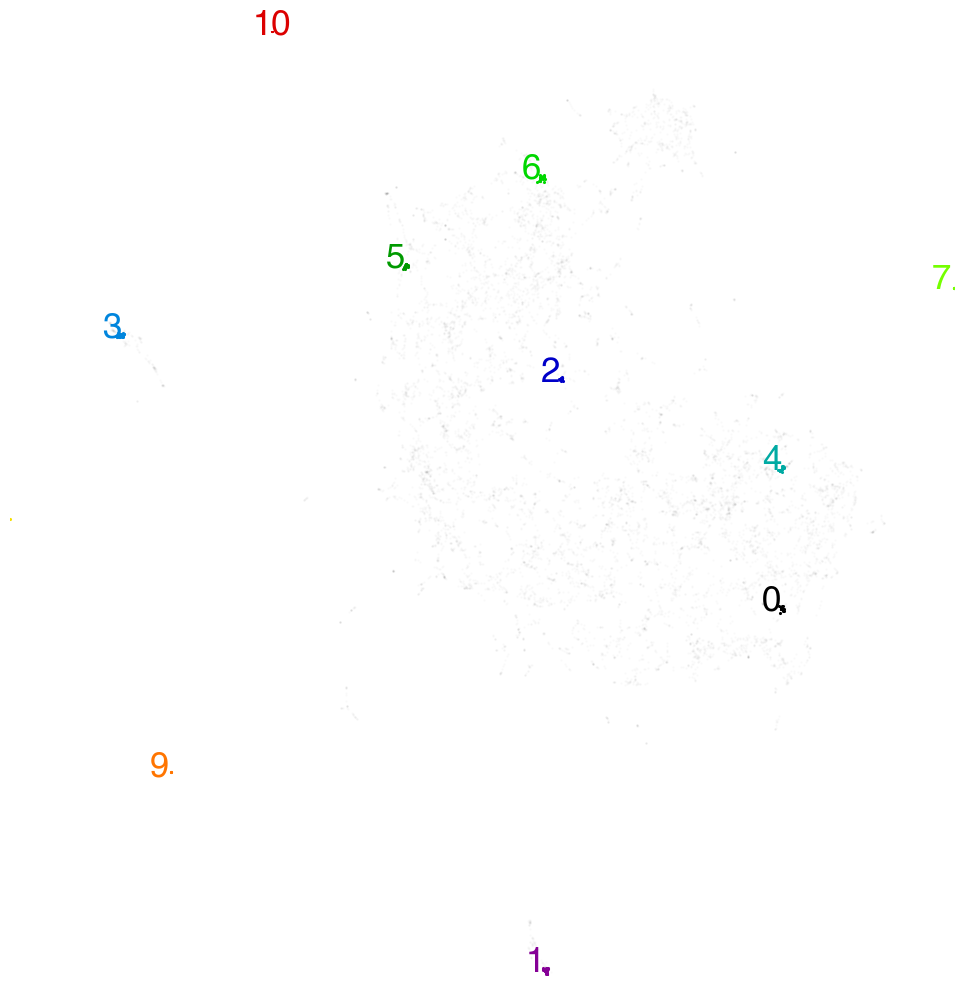

In [10]:
%matplotlib inline 
fig, ax = plt.subplots(figsize=(10,10))
sns.despine(left=True, bottom=True, right=True)

# colors
cmap = plt.get_cmap('nipy_spectral')
cmap_idx = np.linspace(0, 0.9, nEM)

# Color Scatter with sampled pixels
ax.scatter(embeddings[:,dim_a],embeddings[:,dim_b],c='k',s=1, alpha=0.01)
ax.set_ylim([ymin, ymax])
ax.set_xlim([xmin, xmax])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_aspect('equal')

# Plot pixels used to select endmembers
for i in range(0,len(x)):
    ax.scatter(centroid[i].transpose()[0], centroid[i].transpose()[1], color=list(cmap(cmap_idx[i])), s=1.5, alpha = 1)

# Endmembers annotation
label = [val for val in list(range(len(x)))]
#label = ['X' for val in list(range(len(x)))] 
centroids = np.array(x).transpose()
    
for i, txt in enumerate(label):
    ax.annotate(txt, (centroids[0][i]-0.02, centroids[1][i]), color= list(cmap(cmap_idx[i])), size=25)  

fig.tight_layout()
#plt.savefig('../png/figure_2Embeddings_new.png',dpi=300)
plt.show()

## Compute the endmembers

In [11]:
endmember_spectra = []
for i in range(0, len(x)):
    jj = np.mean(spectrum_2D[n_sample_train][F[i]], axis = 0)
    endmember_spectra.append(jj)
endmember_spectra = np.array(endmember_spectra).transpose()

## Plot the endmember spectra

(0.0, 20.0)

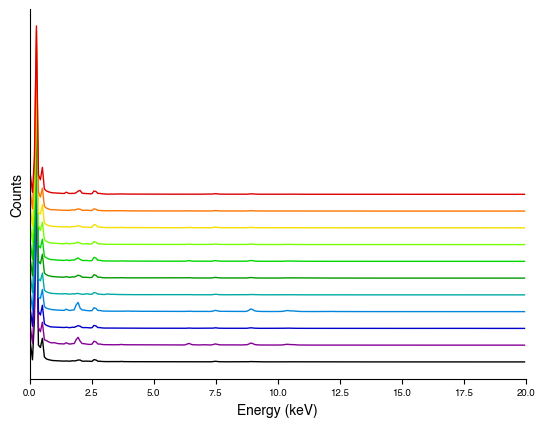

In [12]:
%matplotlib inline
# offset, plot and save all endmember spectra
endmember_spectra_offset = np.copy(endmember_spectra)
endmember_spectra_offset = (endmember_spectra_offset - np.min(endmember_spectra_offset))/(np.max(endmember_spectra_offset) - np.min(endmember_spectra_offset))

seperation_interval = 1/endmember_spectra_offset.shape[1]
for i in range(endmember_spectra_offset.shape[1]):
    endmember_spectra_offset[:,i] += (i*seperation_interval)

    
cmap = plt.get_cmap('nipy_spectral')
cmap_idx = np.linspace(0, 0.9, endmember_spectra_offset.shape[1])

f, ax = plt.subplots()
for i in range(endmember_spectra_offset.shape[1]):
    ax.plot(xray_energies, 
            endmember_spectra_offset[:,i], 
            color = list(cmap(cmap_idx[i])), 
            linewidth = 1)

ax.set_yticks([])
ax.set_ylabel('Counts')
ax.set_xlabel('Energy (keV)')
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlim(0,20)
#plt.savefig('../png/figure_2Spectra_new.svg')

### VCA

In [ ]:
vca_endmembers, vca_idx, Yp = vca(endmember_spectra,11,verbose=True)
print(vca_idx)

## Unmixing with nnls

In [13]:
start = datetime.now()
abundance_maps = np.array([nnls(endmember_spectra,i)[0] for i in spectrum_2D]).transpose()
end = datetime.now()
print('Duration: {}'.format(end - start))

Duration: 0:00:35.176951


## Visualize abundance maps

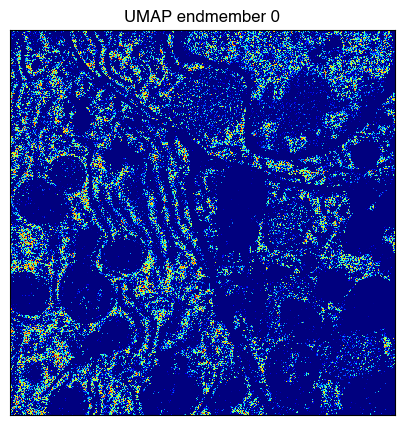

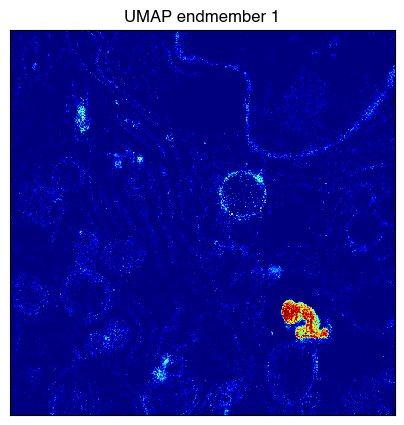

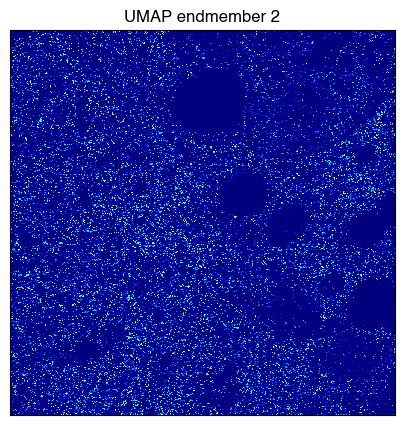

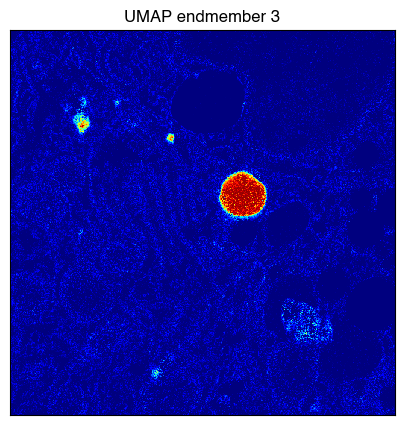

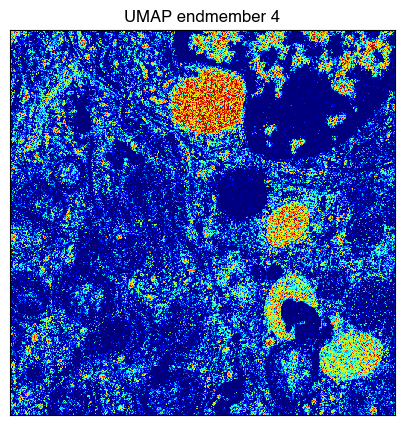

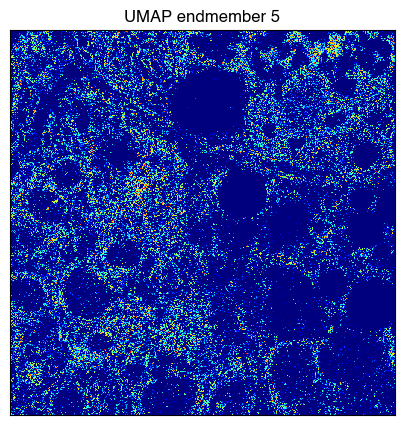

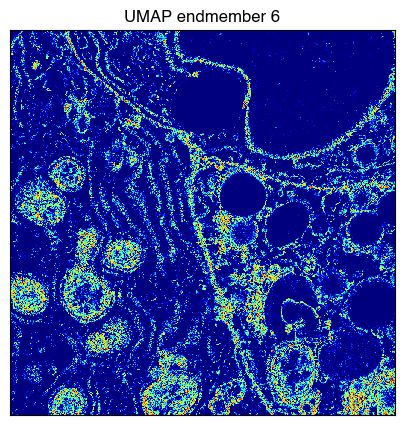

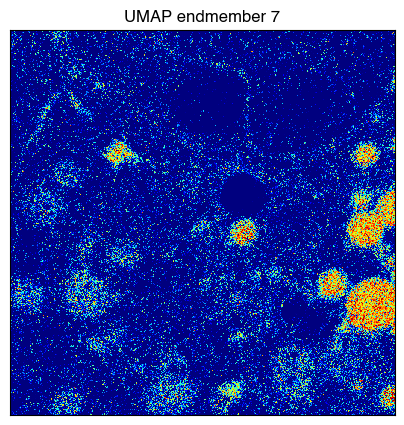

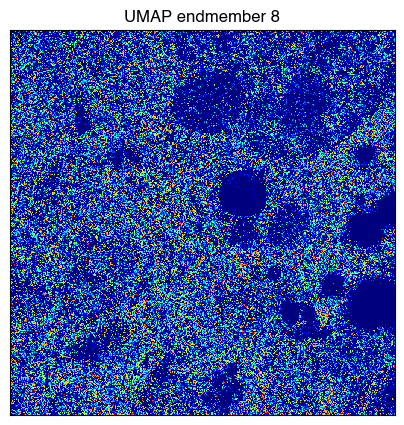

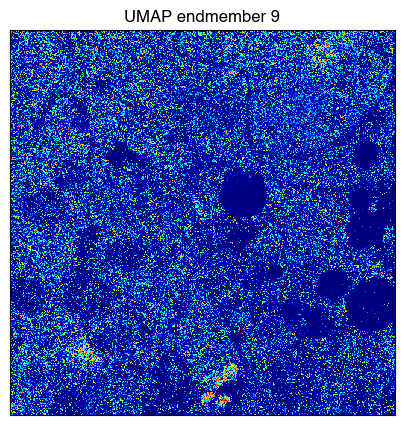

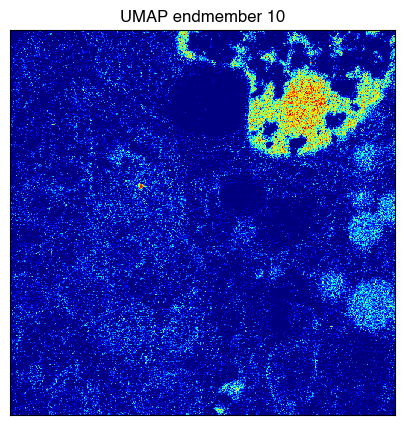

In [14]:
%matplotlib inline 
abundance_maps = np.reshape(abundance_maps,(np.shape(abundance_maps)[0],res_xy,res_xy))
abundance_maps = nnls_maxcf(abundance_maps)
cmap = 'jet'

for ends in range(np.shape(abundance_maps)[0]):
    fig, ax = plt.subplots(figsize=(5,5))    
    ax.imshow(abundance_maps[ends], interpolation='nearest',cmap=cmap, vmin = 0)
    ax.set_title('UMAP endmember ' + str(ends))
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    #im = Image.fromarray(255-(abundance_maps[ends]*255).astype('uint8'))
    #im.save("../../secondary_data/Figure2_abundancemaps/%02d.png" % ends)
    plt.show()



In [ ]:
### Visualize closly (beta)

In [ ]:
cmap = 'jet'
em1 = 10; em2 = 10
fig,ax = plt.subplots(2,3,figsize=(10,10))
ax[0][0].imshow(abundance_maps[em1], interpolation='nearest',cmap=cmap, vmin = 0)
ax[0][0].set_title('UMAP endmember ' + str(2))
ax[0][0].axes.get_xaxis().set_visible(False)
ax[0][0].axes.get_yaxis().set_visible(False)

ax[0][1].imshow(spectrum_2D[:,39].reshape((res_xy,res_xy)), interpolation='nearest',cmap=cmap, vmin = 0)
ax[0][1].set_title('Cadmium')
ax[0][1].axes.get_xaxis().set_visible(False)
ax[0][1].axes.get_yaxis().set_visible(False)

ax[0][2].imshow(haadf, interpolation='nearest',cmap='gray_r', vmin = 0)
ax[0][2].set_title('Haadf')
ax[0][2].axes.get_xaxis().set_visible(False)
ax[0][2].axes.get_yaxis().set_visible(False)


# Thresholded
ax[1][0].imshow(abundance_maps[em1][100:300,400:650], interpolation='nearest',cmap=cmap, vmin = 0)
ax[1][0].set_title('UMAP endmember ' + str(2))
ax[1][0].axes.get_xaxis().set_visible(False)
ax[1][0].axes.get_yaxis().set_visible(False)

ax[1][1].imshow(spectrum_2D[:,39].reshape((res_xy,res_xy))[100:300,400:650], interpolation='nearest',cmap=cmap, vmin=0)
ax[1][1].set_title('Cadmium')
#ax[1][1].axes.get_xaxis().set_visible(False)
#ax[1][1].axes.get_yaxis().set_visible(False)

ax[1][2].imshow(haadf[100:300,400:650], interpolation='nearest',cmap='gray_r', vmin =0)
ax[1][2].set_title('Haadf')
ax[1][2].axes.get_xaxis().set_visible(False)
ax[1][2].axes.get_yaxis().set_visible(False)

